# Demand Planning

This practice dataset comes from Kaggle's Store Item Demand Forecasting Challenge found at https://www.kaggle.com/c/demand-forecasting-kernels-only

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

In [1]:
# Import packages
import os
os.getcwd()
base = 'C:\\Users\\kxr6264'
os.chdir(base)

# data cleaning and viz packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import calendar as calendar
# !pip install holidays
import holidays

# time series modeling packages
#!pip install pmdarima
#!pip install yfinance
import yfinance as yfimport 
import pmdarima as pm
from pmdarima.arima import ADFTest
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

# Import data 
df = pd.read_csv(base + '\\dp_train.csv') # imports data as a data frame

df.head(10) # preview first 10 rows

,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10
5,1/6/2013,1,1,12
6,1/7/2013,1,1,10
7,1/8/2013,1,1,9
8,1/9/2013,1,1,12
9,1/10/2013,1,1,9


# Exploratory Data Analysis

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [3]:
# find uniqure values for columns to determine spread of data
df["store"].unique() # 10 different stores

df["item"].unique() # 50 different items

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [4]:
#print(df.dtypes)
# Convert date to a date/time var
df['date'] =  pd.to_datetime(df['date'])

# convert store and item into text
df['store'] = df['store'].apply(lambda store: str(store)) 
df['item'] = df['item'].apply(lambda item: str(item)) 
print(df.dtypes)


# sort by date important for time series
df = df.sort_values(by=['date','store','item'])
df.head(10)

date     datetime64[ns]
store            object
item             object
sales             int64
dtype: object


,date,store,item,sales
0,2013-01-01,1,1,13
164340,2013-01-01,1,10,37
182600,2013-01-01,1,11,37
200860,2013-01-01,1,12,33
219120,2013-01-01,1,13,37
237380,2013-01-01,1,14,22
255640,2013-01-01,1,15,42
273900,2013-01-01,1,16,14
292160,2013-01-01,1,17,13
310420,2013-01-01,1,18,38


## Date Manipulations

In [5]:
### Extract month, day, year from Date into separate columns

# Extract month.
df['month'] = pd.DatetimeIndex(df['date']).month

# Extract day.
df['day_of_month'] = pd.DatetimeIndex(df['date']).day

# Extract year.
df['year'] = pd.DatetimeIndex(df['date']).year

# Extract quarter.
df['quarter'] = pd.DatetimeIndex(df['date']).quarter

### separate out year and month into their own varialbles for eventual dummy variables

# years
df['year_2013']= np.where(df['year'] == 2013, 1, 0)
df['year_2014']= np.where(df['year'] == 2014, 1, 0)
df['year_2015']= np.where(df['year'] == 2015, 1, 0)
df['year_2016']= np.where(df['year'] == 2016, 1, 0)
df['year_2017']= np.where(df['year'] == 2017, 1, 0)

# months
df['jan_dum']= np.where(df['month'] == 1, 1, 0)
df['feb_dum']= np.where(df['month'] == 2, 1, 0)
df['mar_dum']= np.where(df['month'] == 3, 1, 0)
df['apr_dum']= np.where(df['month'] == 4, 1, 0)
df['may_dum']= np.where(df['month'] == 5, 1, 0)
df['jun_dum']= np.where(df['month'] == 6, 1, 0)
df['july_dum']= np.where(df['month'] == 7, 1, 0)
df['aug_dum']= np.where(df['month'] == 8, 1, 0)
df['sept_dum']= np.where(df['month'] == 9, 1, 0)
df['oct_dum']= np.where(df['month'] == 10, 1, 0)
df['nov_dum']= np.where(df['month'] == 11, 1, 0)
df['dec_dum']= np.where(df['month'] == 12, 1, 0)

# extract week day
df['Day of Week'] = df['date'].apply(lambda date: calendar.day_name[date.weekday()]) 

# extract if date falls on a weekend or not. Is the day saturday or sunday - could possibly include friday as weekend.
df['isweekend']= np.where((df['Day of Week'] == "Saturday")| (df['Day of Week'] == "Sunday"), 1, 0)

df.head()

,date,store,item,sales,month,day_of_month,year,quarter,year_2013,year_2014,...,may_dum,jun_dum,july_dum,aug_dum,sept_dum,oct_dum,nov_dum,dec_dum,Day of Week,isweekend
0,2013-01-01,1,1,13,1,1,2013,1,1,0,...,0,0,0,0,0,0,0,0,Tuesday,0
164340,2013-01-01,1,10,37,1,1,2013,1,1,0,...,0,0,0,0,0,0,0,0,Tuesday,0
182600,2013-01-01,1,11,37,1,1,2013,1,1,0,...,0,0,0,0,0,0,0,0,Tuesday,0
200860,2013-01-01,1,12,33,1,1,2013,1,1,0,...,0,0,0,0,0,0,0,0,Tuesday,0
219120,2013-01-01,1,13,37,1,1,2013,1,1,0,...,0,0,0,0,0,0,0,0,Tuesday,0


#### Typically holidays would be an important consideration for time series analyses, but in the Data Description section of our dataset, we were told that holidays were not in effect - so this portion of code will be commented out here but will remain useful for other projects. https://www.kaggle.com/c/demand-forecasting-kernels-only/data

In [6]:
# does date fall on a holiday or not. assuming US holidays.
# https://towardsdatascience.com/5-minute-guide-to-detecting-holidays-in-python-c270f8479387
# full list of supported holidays in over 50 countries -> https://pypi.org/project/holidays/


# preview list of reocgnized holidays for the years in our dataset
# you might want to append other relevant holidays that are not recognized in this list that may have an effect on sales 
# such as Black Friday in the US or company/industry-specific holidays (ex: valentine's day may be more relevant for a jewler than a furniture store)
#years = [2013,2014,2015,2016,2017]
#for date in holidays.UnitedStates(years=years).items():
#   print(date)    

# save the holidays as a separate string to compare against the df 
#US_Holidays = []
#for date in holidays.UnitedStates(years=years).items():
#    US_Holidays.append(str(date[0]))
#df['holidays'] = np.where(datetime.df['date'].isin(holidays), 1,0)

#US_Holidays

# create a separare date value as a string so we can compare to the US holidays string list
#df['date_as_string'] = date.strftime('%m/%d/%Y')
#df['date_as_string'] = df['date'].apply(lambda date: date.strftime('%m/%d/%Y'))
#print(df.dtypes)

# mark date as 1 if it falls on a US holiday, zero otherwise
#df["holiday"] = np.where(df["date"].isin(US_Holidays), 1, 0)

# double check for 1/1/2013 and 7/4/2013
#df.head(189)

In [7]:
# Determines how many years we are working across. In this case, 5 years - 2013,2014,2015,2016,2017.
df["year"].nunique() # 5 different years
df["month"].nunique() # all months
df["day_of_month"].nunique() # all days

31

In [8]:
# Find null values. Filling null values is essential for TS modeling if they exist.
df.isnull().sum()

date            0
store           0
item            0
sales           0
month           0
day_of_month    0
year            0
quarter         0
year_2013       0
year_2014       0
year_2015       0
year_2016       0
year_2017       0
jan_dum         0
feb_dum         0
mar_dum         0
apr_dum         0
may_dum         0
jun_dum         0
july_dum        0
aug_dum         0
sept_dum        0
oct_dum         0
nov_dum         0
dec_dum         0
Day of Week     0
isweekend       0
dtype: int64

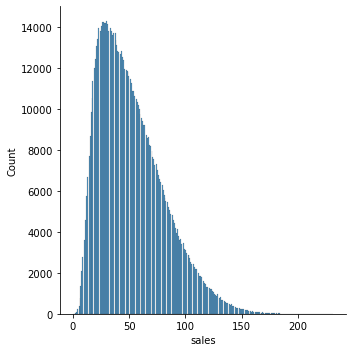

In [9]:
sns.displot(x = df['sales'])

In [10]:
#sns.pairplot(df)

<AxesSubplot:xlabel='month', ylabel='sales'>

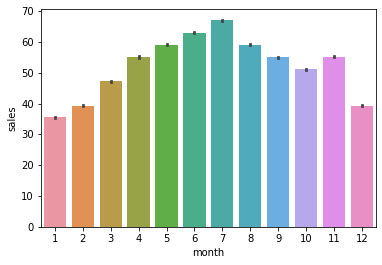

In [11]:
# Observe if seasonality may be present
# summer months seem to bring the most sales, with exception of november. black friday? christmas shoppers?
sns.barplot(x = df['month'], y = df['sales'])

<AxesSubplot:xlabel='store', ylabel='sales'>

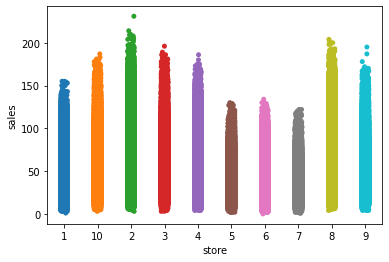

In [12]:
# Look for potential outliers and high erforming stores
# store 2 looks like a high performing store with potential outliers
# store 9 appears to have potential outliers as well
# stores 5-7 a little weaker performance
sns.stripplot(y = df['sales'], x = df['store'])

In [13]:
# describe the df to get summary stats
df.describe()

,sales,month,day_of_month,year,quarter,year_2013,year_2014,year_2015,year_2016,year_2017,...,apr_dum,may_dum,jun_dum,july_dum,aug_dum,sept_dum,oct_dum,nov_dum,dec_dum,isweekend
count,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,...,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000
mean,52.250287,6.523549,15.727820,2015.000548,2.508762,0.199890,0.199890,0.199890,0.200438,0.199890,...,0.082147,0.084885,0.082147,0.084885,0.084885,0.082147,0.084885,0.082147,0.084885,0.285871
std,28.801144,3.448535,8.799329,1.414021,1.117020,0.399918,0.399918,0.399918,0.400328,0.399918,...,0.274588,0.278711,0.274588,0.278711,0.278711,0.274588,0.278711,0.274588,0.278711,0.451828
min,0.000000,1.000000,1.000000,2013.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,4.000000,8.000000,2014.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,47.000000,7.000000,16.000000,2015.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,10.000000,23.000000,2016.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,231.000000,12.000000,31.000000,2017.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# Show the overall pattern of sales data over time 
#fig, ax = plt.subplots(figsize=(20,10))  
#sns.lineplot(x="date", y="sales", data=df, color = 'purple')

In [15]:
# Show facet grid to compare store sales trends side by side
#sns.relplot(
#    data=df, x="date", y="sales",
#    col="store", color = "purple",
#    kind="line"
#)

In [16]:
# heatmap for correlation
#fig, ax = plt.subplots(figsize=(20,10))  
#sns.heatmap(df.corr(), annot = True, cmap = 'gnuplot2_r')

In [17]:
# Rolling averages

# Time Series Modeling
https://medium.com/mlearning-ai/automating-time-series-forecasting-ae74190408be

### PMDArima
https://towardsdatascience.com/efficient-time-series-using-pythons-pmdarima-library-f6825407b7f0
https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

In [18]:
# Here I am going to get a baseline model using just the date and sales before I begin to incorporate other features
# Create a separate DF for this base run
base_model_df = df[['date', 'store', 'sales']].copy()

# set the date column as an index
base_model_df.set_index('date',inplace=True)

base_model_df.head()

,store,sales
date,,
2013-01-01,1,13
2013-01-01,1,37
2013-01-01,1,37
2013-01-01,1,33
2013-01-01,1,37


In [19]:
# Split the data intro train and test groups.
# The orignal Kaggle prompt asked us to predict the last 3 months of sales transactions
#num_stores = base_model_df["store"].nunique()
#len(base_model_df) # total num of rows
#positionfirst75 = len(base_model_df)*0.75
#positionfirst75

# gets most recent date
most_recent_date = base_model_df.index.max()
most_recent_date

# subtract 3 motnhs from most recent date. DateOffset > https://thispointer.com/subtract-months-from-a-date-in-python/
past_3months = most_recent_date - pd.DateOffset(months=3)
past_3months 

# find the iloc position where this date first appears. this will tell us where to cut off the train/test groups
get3months_loc = base_model_df.index.get_loc('2017-09-30 00:00:00')
get3months_loc


# Be careful using sklearn's train test split here because this data is ordered by date and the ordering matters. sklearn's train test split shuffles the data when using its default parameters
# if you want to use sklearn's train test split, use the shuffle=False parameter
# create indicator varible for train_test_group. 
base_model_df['train_test_group'] = base_model_df[['sales']].copy() # add copy of sales column as a placeholder
base_model_df.loc[:866500, "train_test_group"] = 'train'
base_model_df.loc[866500:, "train_test_group"] = 'test'
base_model_df.head(-10)



<ipython-input-19-545f41460ca1>:25: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  base_model_df.loc[:866500, "train_test_group"] = 'train'
<ipython-input-19-545f41460ca1>:26: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  base_model_df.loc[866500:, "train_test_group"] = 'test'


,store,sales,train_test_group
date,,,
2013-01-01,1,13,train
2013-01-01,1,37,train
2013-01-01,1,37,train
2013-01-01,1,33,train
2013-01-01,1,37,train
...,...,...,...
2017-12-31,9,22,test
2017-12-31,9,49,test
2017-12-31,9,61,test


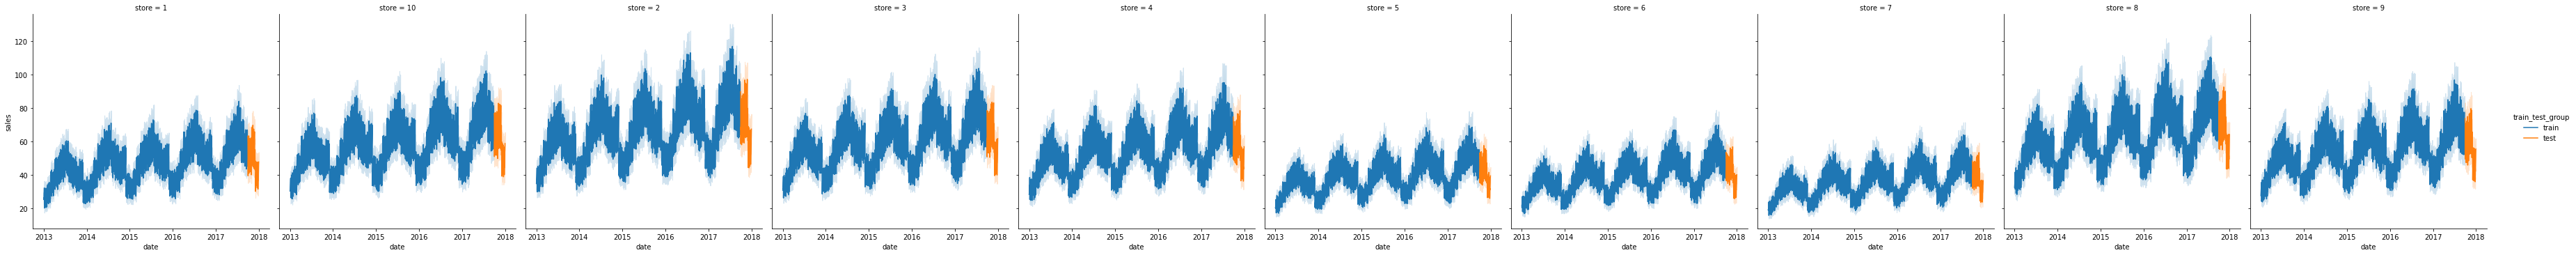

In [20]:
# Show facet grid to compare store sales train and test side by side
#sns.relplot(
#    data=base_model_df, x="date", y="sales",
#    col="store", hue= "train_test_group", 
#    kind="line"
#)

In [21]:
# isolate the train df into its own dataset
train = base_model_df[['store', 'sales','train_test_group']].copy()
train = train[train.train_test_group != "test"] # remove all test obs
train = train.drop('train_test_group', 1) # drop train/test column for data analysis - where 1 is the axis number (0 for rows and 1 for columns.)
train = train.drop('store', 1) # drop store column for data analysis - where 1 is the axis number (0 for rows and 1 for columns.)
train.head(-10)

# isolate the test df into its own dataset
test = base_model_df[['store', 'sales','train_test_group']].copy()
test = test[test.train_test_group != "train"]
test = test.drop('train_test_group', 1) # drop train/test column for data analysis - where 1 is the axis number (0 for rows and 1 for columns.)
test = test.drop('store', 1) # drop store column for data analysis - where 1 is the axis number (0 for rows and 1 for columns.)
test.head(-10)



,sales
date,
2017-09-30,30
2017-09-30,74
2017-09-30,82
2017-09-30,75
2017-09-30,105
...,...
2017-12-31,22
2017-12-31,49
2017-12-31,61


## ADF Test for Stationarity

In [22]:
# use pmdarima’s ADFTest() function to conduct an Augmented Dickey-Fuller test. 
# this is the test that determines if our model is stationary or not, or had a constant mean and variance over time
# The null hypothesis of the test is that the time series is not stationary, while the alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
adf_test=ADFTest(alpha=0.05)

# If the output above shows that the p-value is greater than the significance level of 0.05, 
# we fail to reject the null hypothesis. This means series is not stationary and requires differencing:
adf_test.should_diff(train)

# # Output
# # (0.01, False)
# # This result indicates that the data is not stationary, 
# # so we need to use the “Integrated (I)” concept (d parameter) to make the data stationary while building the Auto ARIMA model.

(0.01, False)

In [23]:
#$ echo 1 > /proc/sys/vm/overcommit_memory
#train['sales'] = train['sales'].astype(np.uint8)

In [24]:
# In the Auto ARIMA model, note that small p,d,q values represent non-seasonal components, 
# and capital P, D, Q represent seasonal components.
# Here, we are trying with the p, d, q values ranging from 0 to 5 to get better optimal values from the model.
from pmdarima import auto_arima
pmdarima_model = auto_arima(train,start_p=0, d=1, start_q=0,
                           max_p=2, max_d=2, max_q=2,
                           start_P=0, D=1, start_Q=0, Max_P=2, max_D=2, max_Q=2, m=12, seasonal=True, error_action ='warn',
                           trace = True, random_state=123, n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=9243910.623, Time=20.41 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8835803.617, Time=361.02 sec


MemoryError: Unable to allocate 4.71 GiB for an array with shape (27, 27, 866501) and data type float64

In [ ]:
pmdarima_model.summary()